In [140]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from tqdm import tqdm 
import datetime

In [141]:
factor_path = "/Users/shezihua/Documents/MAFM/2022-2023 Summer/MAFS 6100L/SummerIndependentProject/factor/"

futureCodeList = ['JBF', 'QWF', 'HCF', 'DBF', 'EHF', 'IPF', 'IIF', 'QXF', 'PEF', 'NAF']
stockCodeList = ['3443', '2388', '2498', '2610', '1319', '3035', '3006', '2615', '5425', '3105']

data_clean_path = '/Users/shezihua/Documents/MAFM/2022-2023 Summer/MAFS 6100L/SummerIndependentProject/dataCleaned/'

In [142]:
futureCode = futureCodeList[0]
stockCode = stockCodeList[0]

In [143]:
stock = pd.read_csv(data_clean_path + futureCode + "-" + stockCode + "/stock.csv.gz", compression='gzip', index_col=0)
future = pd.read_csv(data_clean_path + futureCode + "-" + stockCode + "/future.csv.gz", compression='gzip', index_col=0)
spread = np.log(stock['price']) - np.log(future['midQ'])
spread = pd.DataFrame(spread)
spread.columns = ['spread']

In [144]:
pool = pd.DataFrame()
pool.index = stock.index
pool['SP1'] = stock['SP1']
pool['BP1'] = stock['BP1']
pool['askPrice1'] = future['askPrice1']
pool['bidPrice1'] = future['bidPrice1']
pool['spread'] = spread['spread']
pool.index = pd.to_datetime(pool.index)

trade = pd.DataFrame()
trade.index = pool.index
trade['spread'] = pool['spread']
trade['signal'] = 0
trade['cap'] = 0
trade['pnl'] = 0
trade.index = pd.to_datetime(trade.index)

benchmark

In [145]:
day_list = np.unique(pool.index.date)
train_period = 3
PnLb = np.array([0])

for i in tqdm(range(len(day_list) - train_period)[-30:]):
    train_start_time = trade.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train = trade[train_start_time & train_end_time]
    test_start_time = trade.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test = trade[test_start_time & test_end_time]

    current_pool = pool[test_start_time & test_end_time]

    mean = np.mean(train['spread'])
    std = np.std(train['spread'])

    upper = mean + 1.5 * std
    lower = mean - 1.5 * std

    for tick_idx in (range(len(test.index))): 
        current_data = test[0:tick_idx + 1]

        if tick_idx != len(test.index) - 1:
            # long spread
            if test.loc[test.index[tick_idx]]['spread'] <= lower: 
                if np.sum(current_data['signal']) == 0: 
                    test.at[test.index[tick_idx], 'signal'] = 1
                    test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']

            # back to mean
            elif test.loc[test.index[tick_idx]]['spread'] >= mean: 
                if np.sum(current_data['signal']) == 1: 
                    test.at[test.index[tick_idx], 'signal'] = -1
                    test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']

            # short spread
            elif test.loc[test.index[tick_idx]]['spread'] >= upper: 
                if np.sum(current_data['signal']) == 0: 
                    test.at[test.index[tick_idx], 'signal'] = -1
                    test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']

            # back to mean 
            elif test.loc[test.index[tick_idx]]['spread'] <= mean: 
                if np.sum(current_data['signal']) == -1: 
                    test.at[test.index[tick_idx], 'signal'] = 1
                    test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap'])# + trade.loc[test.index[tick_idx]]['cap']

            else: 
                pass
        
        else:
            if np.sum(current_data['signal']) == 1: 
                test.at[test.index[tick_idx], 'signal'] = -1
                test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            elif np.sum(current_data['signal']) == -1: 
                test.at[test.index[tick_idx], 'signal'] = 1
                test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            else:
                pass
    
    
    PnLb = np.append(PnLb, test[test['pnl'] != 0]['pnl'] + PnLb[-1])

100%|██████████| 30/30 [02:21<00:00,  4.73s/it]


In [146]:
PnLb

array([     0,   1000,   1500,   2500,   3000,   3500,   4500,   5000,
         5500,   6000,   7000,   8000,   8500,   9000,  10000,  11000,
        12000,  12500,  13000,  14000,  15000,  16000,  16500,  17000,
        17500,  18000,  18500,  19500,  20500,  21000,  22000,  23000,
        23500,  24500,  25500,  26500,  27500,  28500,  29500,  30000,
        30500,  31500,  32500,  33000,  33500,  34000,  35500,  36500,
        37000,  37500,  38500,  39500,  40000,  41000,  41500,  42500,
        43500,  44500,  45000,  45500,  46500,  47500,  47500,  48000,
        49000,  49500,  50500,  51000,  51500,  52500,  53500,  54500,
        55500,  56000,  56500,  57000,  57500,  58500,  59500,  60000,
        61000,  61500,  62000,  62000,  63000,  64000,  65000,  66000,
        66500,  67500,  68500,  69500,  70000,  70500,  71500,  72500,
        73500,  74500,  75000,  76000,  77000,  77500,  78000,  79000,
        80000,  80500,  81500,  82000,  82500,  83000,  83500,  84000,
      

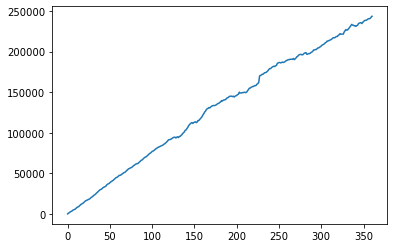

In [147]:
plt.plot(PnLb)

delay

In [148]:
day_list = np.unique(pool.index.date)
train_period = 3
PnLd = np.array([0])


for i in tqdm(range(len(day_list) - train_period)[-30:]):
    train_start_time = trade.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train = trade[train_start_time & train_end_time]
    test_start_time = trade.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test = trade[test_start_time & test_end_time]

    current_pool = pool[test_start_time & test_end_time]

    mean = np.mean(train['spread'])
    std = np.std(train['spread'])

    upper = mean + 1.5 * std
    lower = mean - 1.5 * std

    for tick_idx in (range(len(test.index))): 
        current_data = test[0:tick_idx + 1]

        if tick_idx != len(test.index) - 9:
            # generate delay
            delay_idx = np.random.rand()
            delay = 0
            if delay_idx < np.sin(np.pi/8*3):
                pass
            else: 
                delay = 6

            # long spread
            if test.loc[test.index[tick_idx]]['spread'] <= lower: 
                if np.sum(current_data['signal']) == 0: 
                    test.at[test.index[tick_idx+delay], 'signal'] = 1
                    test.at[test.index[tick_idx+delay], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']

            # back to mean
            elif test.loc[test.index[tick_idx]]['spread'] >= mean: 
                if np.sum(current_data['signal']) == 1: 
                    test.at[test.index[tick_idx+delay], 'signal'] = -1
                    test.at[test.index[tick_idx+delay], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                    test.at[test.index[tick_idx+delay], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']

            # short spread
            elif test.loc[test.index[tick_idx]]['spread'] >= upper: 
                if np.sum(current_data['signal']) == 0: 
                    test.at[test.index[tick_idx+delay], 'signal'] = -1
                    test.at[test.index[tick_idx+delay], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']

            # back to mean 
            elif test.loc[test.index[tick_idx]]['spread'] <= mean: 
                if np.sum(current_data['signal']) == -1: 
                    test.at[test.index[tick_idx+delay], 'signal'] = 1
                    test.at[test.index[tick_idx+delay], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                    test.at[test.index[tick_idx+delay], 'pnl'] = np.sum(current_data['cap'])# + trade.loc[test.index[tick_idx]]['cap']

            else: 
                pass
        
        else:
            pass
            if np.sum(current_data['signal']) == 1: 
                test.at[test.index[tick_idx], 'signal'] = -1
                test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            elif np.sum(current_data['signal']) == -1: 
                test.at[test.index[tick_idx], 'signal'] = 1
                test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            else:
                pass
    
    
    PnLd = np.append(PnLd, test[test['pnl'] != 0]['pnl'] + PnLd[-1])

100%|██████████| 30/30 [02:24<00:00,  4.82s/it]


In [149]:
PnLd

array([     0,   1000,   1500,   2500,   3000,   3500, 119000,   5000,
         6000,   6500, 122500,   8500,   9000,  10000,  11000,  11500,
        12000,  13000,  14000,  15000,  15500,  16000,  17000, 132000,
       132000, 133000, 133500, 134000, 135000, 136000, 250000, 137500,
       138000, 139000, 139500, 140500, 141500, 142500, 143000, 143500,
       144500, 145500, 145500, 146000, 147000, 147500, 148500, 149000,
       149500, 150500, 151500, 152500, 153500, 154000, 154500, 155000,
       155500, 156500, 157500, 158000, 159000, 159500, 160000, 275500,
       161000, 161000, 162000, 163000, 164000, 165000, 166500, 167000,
       167000, 167500, 168000, 169000, 169500, 170000, 170000, 169000,
       170000, 170500, 169500, 171000, 302000, 172500, 172500, 172000,
       172500, 173000, 174000, 174500, 175000, 176000, 176500, 178000,
       177500, 178500, 179000, 179000, 179500, 180000, 180000, 327500,
       181000, 181500, 183000, 191000, 192000, 193000, 193000, 193500,
      

In [150]:
PnLd[PnLd<1000]

array([0])

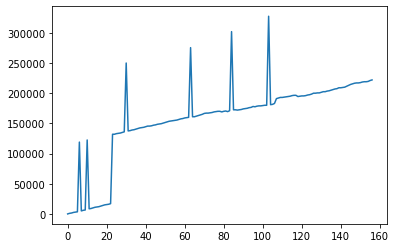

In [153]:

plt.plot(PnLd)

JBF


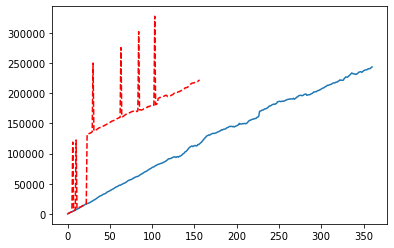

In [154]:
print(futureCode)
plt.plot(PnLb)
plt.plot(PnLd, color='red', linestyle='--')